# **Εργασία 2 - Τεχνικές Εξόρυξης Δεδομένων**
Ονοματεπώνυμα: Αλέξανδρος Κούτρας

Α.Μ: 1115202100073

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install gensim

In [ ]:
pip install -U datasets

In [37]:
import re
import ast
import nltk
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.sparse import hstack
from wordcloud import WordCloud
from datasets import load_dataset
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# **Task 1: Clustering for Product Grouping**
Extract data for any five categories that you like. Parse the JSON files and create the csv file(s) that you are going to use for the rest of the Tasks.

In [40]:
# Read the JSON file using the given load_dataset function
meta_Electronics = load_dataset("McAuley-Lab/Amazon-Reviews-2023", name="raw_meta_Electronics", split="full", streaming=True, trust_remote_code=True)
reviews_Electronics = load_dataset("McAuley-Lab/Amazon-Reviews-2023", name="raw_review_Electronics", split="full", streaming=True, trust_remote_code=True)

# Add to a list the unnecessary columns and remove them from the dataset
meta_columns_to_remove = ['images', 'bought_together', 'subtitle', 'author', 'videos']
meta_Electronics = meta_Electronics.remove_columns(meta_columns_to_remove)
reviews_Electronics = reviews_Electronics.remove_columns(['images'])

subset_meta_Electronics = []
subset_reviews_Electronics = []

# Iterate through the dataset and keep a number of rows
for record in meta_Electronics:
  subset_meta_Electronics.append(record)
  if len(subset_meta_Electronics) >= 10000:
    break

for record in reviews_Electronics:
  subset_reviews_Electronics.append(record)
  if len(subset_reviews_Electronics) >= 10000:
    break

# Create the pandas dataframe
pandas_subset_meta_Electronics = pd.DataFrame(subset_meta_Electronics)
pandas_subset_reviews_Electronics = pd.DataFrame(subset_reviews_Electronics)

# Rename a column so there are no conflicts on the merge
pandas_subset_meta_Electronics.rename(columns={'title': 'name'}, inplace=True)

# Merge the 2 datasets using as key the parent_asin column and the reviews dataframe as the left merger
electronics = pd.merge(pandas_subset_reviews_Electronics,pandas_subset_meta_Electronics,on='parent_asin',how='left')

# Drop all the NaN values from the dataframe
electronics = electronics.dropna()

#Save the dataframe to a csv file
electronics.to_csv('electronics.csv', index=False)

Clean and prepare the text data for model training by standardizing the
input

In [41]:
# Read the csv file we created earlier
electronics = pd.read_csv("electronics.csv")

# We drop all the NaN values from the dataset
electronics.dropna(inplace=True)
electronics.reset_index(drop=True, inplace=True)

# These are the stop words that we will remove from the columns
stop_words = set(stopwords.words('english'))

def clean_text(text):
  # We only keep the letters and the spaces and we transform them to lower case letters
  cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
  cleaned_text = cleaned_text.lower()

  # We remove the stopwords
  words = cleaned_text.split()
  filtered_words = [word for word in words if word not in stop_words]

  # We combine all the words to one string
  text = ' '.join(filtered_words)
  return text

# Apply the preprocessing function to the description column
electronics['processed_description'] = electronics['description'].apply(clean_text)

# Scale all the numeric columns
scaler = StandardScaler()
numerical_features = ['price', 'rating']
scaled_numerical_features = ['scaled_price', 'scaled_rating']
electronics[scaled_numerical_features] = scaler.fit_transform(electronics[numerical_features])

print("\nPreprocessed Descriptions:")
print(electronics[['description', 'processed_description', 'price', 'rating', 'scaled_price', 'scaled_rating']].head())


Preprocessed Descriptions:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Use TF-IDF for vectorization of product descriptions and combine numerical features and TF-IDF vectors into a single feature matrix.

In [42]:
# Vectorize text data using TF-IDF
tf_electronics = TfidfVectorizer(max_features=1000)
train_electronics = tf_electronics.fit_transform(electronics['processed_description'])

# Combine TF-Electronics with scaled numerical features
scaled_numerical = electronics[scaled_numerical_features].values
combined_features = hstack([train_electronics, scaled_numerical])

Perform clustering using one clustering method.

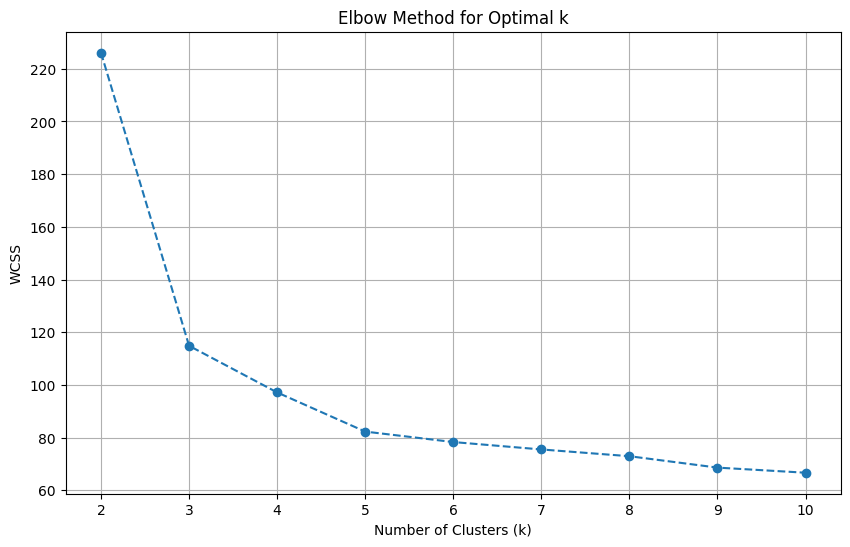

In [43]:
# Perform the Elbow method to find the optimal k value
wcss = []

# Test k from 2 to 10
k_range = range(2, 11)

# Perform the k-Means algorithm for the k range
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(combined_features)

    # Keep the inertia to compare in the graph
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [44]:
# Perform the k-Means algorithm for the optimal k value we found from the Elbow method above
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
electronics['cluster'] = kmeans.fit_predict(combined_features)

print(f"\nClustering complete with {optimal_k} clusters.")
print(electronics.head())


Clustering complete with 3 clusters.
   rating                                         title  \
0     4.0  Did anyone use this for a recessed TV mount?   
1     1.0                                          Junk   
2     5.0                    Right size for kids Kindle   
3     3.0  Definitely not for me, but maybe for my sons   
4     5.0                                     finally !   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Visualize clusters using dimensionality reduction
techniques

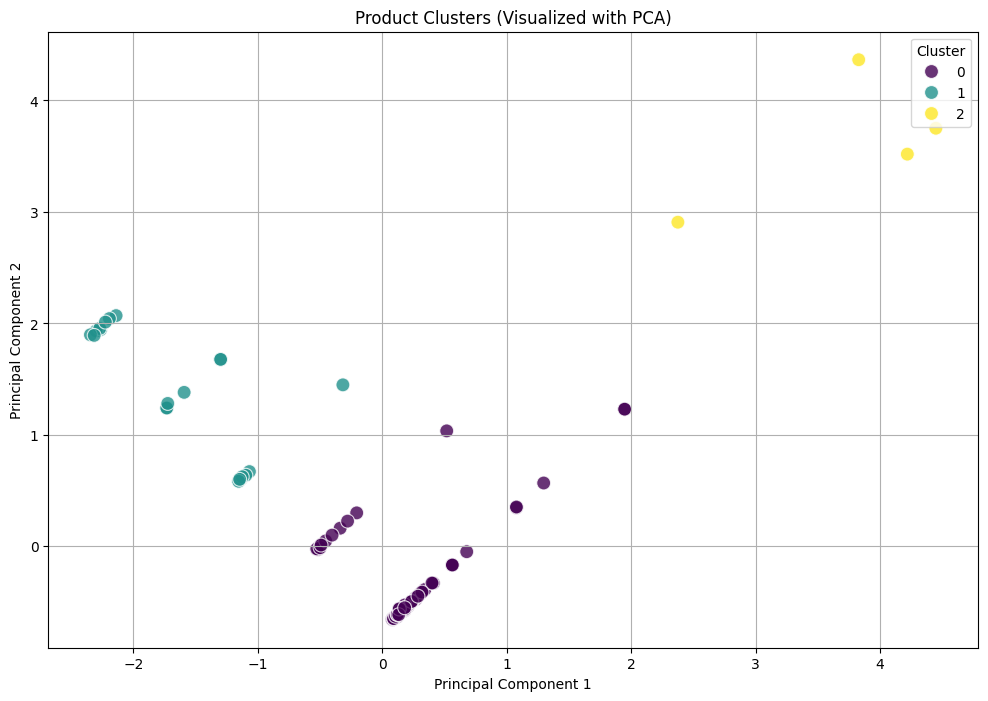

In [45]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(combined_features.toarray())

# Add reduced features to DataFrame
electronics['pca1'] = reduced_features[:, 0]
electronics['pca2'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=electronics, palette='viridis', s=100, alpha=0.8)
plt.title('Product Clusters (Visualized with PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Silhouette Score: Measures how similar items within a cluster are compared to items in other clusters.

In [46]:
# Use the silhouette analysis to see how good the clustering is done
score = silhouette_score(combined_features, electronics['cluster'])
print(f"\nSilhouette Score for k={optimal_k}: {score:.3f}")


Silhouette Score for k=3: 0.574


In [47]:
# Analyze the top terms per cluster
print("\nTop Terms per Cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_electronics.get_feature_names_out()

for i in range(optimal_k):
    # Get top 10 terms, ensuring indices are within the bounds of the terms array
    top_terms_indices = [ind for ind in order_centroids[i, :] if ind < len(terms)][:10]
    top_terms = [terms[ind] for ind in top_terms_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Top Terms per Cluster:
Cluster 0: cable, laptop, inch, ft, product, usb, connector, amazon, basics, ipad
Cluster 1: mouse, bluetooth, charge, open, usb, keyboard, windows, ipad, fitbit, computer
Cluster 2: gb, google, ghz, windows, home, hd, requires, may, pixel, laptop


# **Task 2: Recommendation System**

Collaborative Filtering




In [56]:
# We only keep the neccessary columns
cf_electronics = electronics[['user_id', 'asin', 'rating']].copy()

# For better results we'll only use active users and products that have been rated a lot
user_counts = cf_electronics['user_id'].value_counts()
item_counts = cf_electronics['asin'].value_counts()

cf_electronics = cf_electronics[cf_electronics['user_id'].isin(user_counts[user_counts >= 1].index)]
cf_electronics = cf_electronics[cf_electronics['asin'].isin(item_counts[item_counts >= 1].index)]

In [57]:
# Create the user-item matrix
user_item_matrix = cf_electronics.pivot_table(index='user_id', columns='asin', values='rating').fillna(0)

# Calculate user similarity
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Perform user based collaborative filtering
def get_user_based_recommendations(user_id, k=5):
  # Find the top most similar users
  similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:k+1]

  # Get the items the users have rated excluding the target user items
  similar_users_items = user_item_matrix.loc[similar_users]
  user_items = user_item_matrix.loc[user_id]

  recommendations = {}
  for item in similar_users_items.columns:
    # Only consider items the target user hasn't rated yet
    if user_items[item] == 0:
      weighted_sum = 0
      similarity_sum = 0
      for similar_user in similar_users:
        # If the similar user has rated this item
        if similar_users_items.loc[similar_user, item] > 0:
          # Get similarity between target user and similar user
          similarity = user_similarity_df.loc[user_id, similar_user]

          # Add to weighted sum and similarity sum
          weighted_sum += similar_users_items.loc[similar_user, item] * similarity
          similarity_sum += similarity

        # Calculate predicted rating
        if similarity_sum > 0:
          recommendations[item] = weighted_sum / similarity_sum

  # Sort the recommendations by predicted rating in descending order
  sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
  return sorted_recommendations

# Calculate item similarity
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Perform item based collaborative filtering
def get_item_based_recommendations(user_id, k=5):
  user_ratings = user_item_matrix.loc[user_id]
  rated_items = user_ratings[user_ratings > 0].index

  recommendations = {}
  for item in user_item_matrix.columns:
    # Only consider items the target user hasn't rated yet
    if user_ratings[item] == 0:
      weighted_sum = 0
      similarity_sum = 0
      for rated_item in rated_items:
        similarity = item_similarity_df.loc[item, rated_item]

        # Add to weighted sum and similarity sum
        if similarity > 0:
          weighted_sum += user_ratings[rated_item] * similarity
          similarity_sum += similarity

      # Calculate predicted rating if valid contributors exist
      if similarity_sum > 0:
        recommendations[item] = weighted_sum / similarity_sum

  sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
  return sorted_recommendations


sample_user_id = cf_electronics['user_id'].iloc[0]

print(f"\n--- Recommendations for user: {sample_user_id} ---")
print("\nUser-Based CF Recommendations (Top 5):")
print(get_user_based_recommendations(sample_user_id, 5)[:5])
print("\nItem-Based CF Recommendations (Top 5):")
print(get_item_based_recommendations(sample_user_id, 5)[:5])


--- Recommendations for user: AEVWAM3YWN5URJVJIZZ6XPD2MKIA ---

User-Based CF Recommendations (Top 5):
[]

Item-Based CF Recommendations (Top 5):
[]


Content-Based Filtering

In [58]:
# Data preparation for Content-Based Filtering
cbf_electronics = electronics[['asin', 'title', 'description', 'price', 'main_category']].copy()
cbf_electronics.drop_duplicates(subset=['asin'], inplace=True)
cbf_electronics.set_index('asin', inplace=True)

# Load the stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
  # We only keep the letters and the spaces and we transform them to lower case letters
  cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
  cleaned_text = cleaned_text.lower()

  # We remove the stopwords
  words = cleaned_text.split()
  filtered_words = [word for word in words if word not in stop_words]

  # We combine all the words to one string
  text = ' '.join(filtered_words)
  return text

# Ensure both columns are strings before concatenating
cbf_electronics['processed_text'] = cbf_electronics['title'].astype(str) + " " + cbf_electronics['description'].astype(str).fillna('')
cbf_electronics['processed_text'] = cbf_electronics['processed_text'].apply(clean_text)

# Normalize the price column
scaler = MinMaxScaler()
def clean_price(price):
  try:
    return float(price)
  except ValueError:
    return np.nan

cbf_electronics['price'] = cbf_electronics['price'].apply(clean_price)
cbf_electronics.dropna(subset=['price'], inplace=True)
cbf_electronics['price_scaled'] = scaler.fit_transform(cbf_electronics[['price']])

# Add the scaled price column to the column we aregoing to use for the recommendations
cbf_electronics['processed_text'] = cbf_electronics['processed_text'] + " " + cbf_electronics['price_scaled'].astype(str)

In [59]:
# Train the word2vec model
sentences = [text.split() for text in cbf_electronics['processed_text']]
word2vec_electronics = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_document_vector(text, model):
  # Split the text to tokens
  tokens = text.split()

  # Create a vector and initialize it to 0
  vector = np.zeros(model.vector_size)
  count = 0

  # Iterate through all words
  for word in tokens:
    # If word exists in model add it to the document
    if word in model.wv:
      vector += model.wv[word]
      count += 1
  if count != 0:
    vector /= count
  return vector

cbf_electronics['vector'] = cbf_electronics['processed_text'].apply(lambda x: get_document_vector(x, word2vec_electronics))

# Calculate cosine similarity between product vectors
products = np.array(cbf_electronics['vector'].tolist())
product_similarity = cosine_similarity(products)
product_similarity_df = pd.DataFrame(product_similarity, index=cbf_electronics.index, columns=cbf_electronics.index)

# Get recommendations for a sample product
sample_product_asin = cbf_electronics.index[0]
num_recommendations = 5

print(f"\n--- CBF Recommendations for product: {sample_product_asin} ---")
# Get similarity scores for the sample product, sort them, and get top recommendations
similar_products = product_similarity_df[sample_product_asin].sort_values(ascending=False).index[1:num_recommendations+1]

# Retrieve the details of the recommended products
recommended_products_details = cbf_electronics.loc[similar_products]
print(recommended_products_details)


--- CBF Recommendations for product: B001PL3XJS ---
                                                                             title  \
asin                                                                                 
B01L1HH5TY                                                       Excellent Product   
B000067SPK                                                              Four Stars   
B00J7IHRPW               Long Lightning Cable Is Sturdy, Reliable, Apple-Certified   
B00X7B1OK4  Soo compact and sense of tidiness on extremely cluttered desk and case   
B00JWTVNU6                                             Nice cord, 2 year warranty.   

                                                                                                                                                                                                                                                                                                                                                        

Hybrid Approach

In [60]:
def get_hybrid_recommendations(user_id, cf_weight=0.7, cbf_weight=0.3, k=5):
  # Get CF recommendations
  cf_recs = get_item_based_recommendations(user_id, k=len(cbf_electronics))
  cf_scores = {item: score for item, score in cf_recs}

  # Get CBF recommendations
  user_ratings = user_item_matrix.loc[user_id]
  top_rated_item = user_ratings.idxmax()

  cbf_recs = product_similarity_df[top_rated_item].sort_values(ascending=False)

  # Combine scores
  hybrid_scores = {}
  all_items = set(cf_scores.keys()) | set(cbf_recs.index)

  for item in all_items:
    cf_score = cf_scores.get(item, 0)
    cbf_score = cbf_recs.get(item, 0)

    hybrid_scores[item] = (cf_score * cf_weight) + (cbf_score * cbf_weight)

  sorted_hybrid_recs = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
  return sorted_hybrid_recs

print(f"\n--- Hybrid Recommendations for user: {sample_user_id} ---")
print(get_hybrid_recommendations(sample_user_id, k=5)[:5])


--- Hybrid Recommendations for user: AEVWAM3YWN5URJVJIZZ6XPD2MKIA ---
[('B001PL3XJS', 0.30000000000000004), ('B01L1HH5TY', 0.20868626654320174), ('B000067SPK', 0.20421859220722008), ('B00J7IHRPW', 0.20345386325999829), ('B00X7B1OK4', 0.20288198841763805)]


User-Based CF recommends items based on similar users' preferences. It's good at uncovering surprising recommendations and requires no product data but suffers from scalability, sparsity, and cold-start issues for new users.

Item-Based CF suggests items similar to those a user liked. It's more scalable and stable, handles new users better, and works well for static catalogs, but struggles with recommending new items and often repeats popular or obvious choices.

Content-Based Filtering recommends items using product features like descriptions. It's ideal for new items and users with niche tastes and offers explainable results. However, it depends heavily on good metadata and tends to over-specialize.

Hybrid Approaches combine CF and CBF to improve accuracy, diversity, and handle cold-start problems, but they are more complex to build and require careful tuning to balance the models.

# **Task 3: Classification task - sentiment analysis**

In [61]:
# Read the csv file we created earlier
electronics = pd.read_csv("electronics.csv") # Remove this line
electronics = electronics[['text', 'rating']] # Correct column selection

# We drop all the NaN values from the dataset
electronics.dropna(inplace=True)
electronics.reset_index(drop=True, inplace=True)

# These are the stop words that we will remove from the columns
stop_words = set(stopwords.words('english'))

def clean_text(text):
  # We only keep the letters and the spaces and we transform them to lower case letters
  cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(text))
  cleaned_text = cleaned_text.lower()

  # We remove the stopwords
  words = cleaned_text.split()
  filtered_words = [word for word in words if word not in stop_words]

  # We combine all the words to one string
  text = ' '.join(filtered_words)
  return text

# Apply the preprocessing function to the description column
electronics['processed_text'] = electronics['text'].apply(clean_text)

# Create sentiment labels based on rating
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

electronics['sentiment'] = electronics['rating'].apply(to_sentiment)

X_train, X_test, y_train, y_test = train_test_split(electronics['processed_text'], electronics['sentiment'], test_size=0.2, random_state=42, stratify=electronics['sentiment'])

In [34]:
tf_electronics_text = TfidfVectorizer(max_features=1000)
train_electronics_text = tf_electronics_text.fit_transform(X_train)

print("\nTF-IDF Table for data:")
print(train_electronics_text)


TF-IDF Table for data:
  (0, 272)	0.47685816870293435
  (0, 669)	0.5593997059794499
  (0, 253)	0.334083148318454
  (0, 358)	0.5899717839871825
  (1, 105)	0.4319433723606471
  (1, 65)	0.3555929986599345
  (1, 476)	0.44028537574731796
  (1, 908)	0.4268648808380358
  (1, 59)	0.33824172965668237
  (1, 595)	0.4432902391286951
  (2, 320)	0.491900287747801
  (2, 523)	0.46010883629664867
  (2, 109)	0.4563992937547485
  (2, 175)	0.364515642995756
  (2, 924)	0.3131464462045786
  (2, 979)	0.2553817332918766
  (2, 353)	0.20464962711231932
  (3, 353)	0.3823187358758034
  (3, 662)	0.5281667214366694
  (3, 275)	0.7582033358968867
  (4, 954)	0.26529880581832543
  (4, 729)	0.490872773439829
  (4, 116)	0.36030098947910355
  (4, 27)	0.4970357043598686
  (4, 937)	0.4681281112921734
  :	:
  (3639, 659)	0.10505026976689542
  (3639, 435)	0.12096508463581937
  (3639, 716)	0.12141975740399309
  (3639, 677)	0.09948100012525014
  (3639, 106)	0.4148155632934576
  (3639, 413)	0.13924903273233347
  (3639, 398)	0.1

In [35]:
# Train the word2vec model
sentences = [text.split() for text in X_train]
word2vec_electronics = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Δημιουργία χαρακτηριστικών Word Embeddings
def get_document_vector(text, model):
  # Split the text to tokens
  tokens = text.split()

  # Create a vector and initialize it to 0
  vector = np.zeros(model.vector_size)
  count = 0

  # Iterate through all words
  for word in tokens:
    # If word exists in model add it to the document
    if word in model.wv:
      vector += model.wv[word]
      count += 1
  if count != 0:
    vector /= count
  return vector

# Apply the get_document_vector function only to the training data (X_train)
X_train_w2v = X_train.apply(lambda x: get_document_vector(x, word2vec_electronics))

print("First 5 training set embeddings:")
for i in range(min(5, len(X_train_w2v))):
    print(f"Review {i+1} embedding:", X_train_w2v.iloc[i])

First 5 training set embeddings:
Review 1 embedding: [-0.02234297  0.39769326  0.19473572  0.03743622  0.09950537 -0.81372814
  0.12187432  1.19105072 -0.23682224 -0.15008097 -0.32271956 -0.65743933
 -0.07248559  0.27160689  0.11785648 -0.44523001  0.05986261 -0.73005445
 -0.11101839 -0.89008656  0.32339739  0.08719138  0.43997563 -0.2321677
 -0.06393616 -0.12317101 -0.23083555 -0.29521351 -0.37133193  0.11759018
  0.53349995 -0.02270923  0.1810362  -0.40105005 -0.14367443  0.5867046
  0.01388659 -0.69315363 -0.28723674 -1.03745639  0.08147034 -0.42684495
 -0.22187474 -0.09109081  0.37243883 -0.1663863  -0.38444781  0.06515115
  0.17579409  0.32208901  0.14209801 -0.32605719 -0.14886681 -0.07146822
 -0.26102101  0.28451931  0.37197217 -0.02857377 -0.58911408  0.034175
  0.22123859  0.10736371 -0.24815527 -0.02636057 -0.66408224  0.48083725
  0.25688754  0.228486   -0.89712426  0.64101823 -0.41738466  0.0722617
  0.70552019 -0.19288858  0.40214321  0.15265646  0.02604772 -0.09748581
 -0

In [36]:
models = {
    'TF-IDF_NB': Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('nb', MultinomialNB())]),
    'TF-IDF_KNN': Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('knn', KNeighborsClassifier(n_neighbors=5))]),
    'TF-IDF_Random Forest': Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('rf', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'Embeddings_NB': GaussianNB(),
    'Embeddings_KNN': KNeighborsClassifier(n_neighbors=5),
    'Embeddings_Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

def evaluate_model_cv(model, X, y, scoring):
  scores = cross_val_score(model, X, y, cv=10, scoring=scoring)
  return scores.mean(), scores.std()

cv_results = {}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("\nRunning 10-fold cross-validation... (This may take a while)")

# Convert X_train_w2v to a NumPy array for cross-validation
X_train_w2v_array = np.array(X_train_w2v.tolist())

for name, model in models.items():
    print(f"Evaluating {name}...")
    if 'TF-IDF' in name:
        X_cv = X_train
    else:
        X_cv = X_train_w2v_array

    for metric in scoring_metrics:
        mean, std = evaluate_model_cv(model, X_cv, y_train, metric)
        feature_set = 'TF-IDF' if 'TF-IDF' in name else 'Embeddings'
        model_name = name.split('_')[1] if '_' in name else name
        if (feature_set, model_name) not in cv_results:
            cv_results[(feature_set, model_name)] = {}
        cv_results[(feature_set, model_name)][metric] = f"{mean:.3f} (+/- {std:.3f})"

print("Cross-validation complete.")

# --- Display CV results in a table ---
cv_results_df = pd.DataFrame(cv_results).T
cv_results_df.index.names = ['Feature Set', 'Model']
cv_results_df.columns = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
print("\n--- 10-Fold Cross-Validation Results on Training Data ---")
print(cv_results_df)


# --- Evaluate on the test set ---
print("\n--- Evaluating models on the Test Set ---")

# Convert X_test_w2v to a NumPy array for testing
X_test_w2v = X_test.apply(lambda x: get_document_vector(x, word2vec_electronics))
X_test_w2v_array = np.array(X_test_w2v.tolist())

for name, model in models.items():
    print(f"Evaluating {name} on test set...")
    if 'TF-IDF' in name:
        # For TF-IDF pipelines, fit and predict on the original text data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # Need to refit the embeddings models on the entire training data before testing
        if name == 'Embeddings_NB':
            model = GaussianNB()
        elif name == 'Embeddings_KNN':
            model = KNeighborsClassifier(n_neighbors=5)
        elif name == 'Embeddings_Random Forest':
            model = RandomForestClassifier(n_estimators=100, random_state=42)

        model.fit(X_train_w2v_array, y_train)
        y_pred = model.predict(X_test_w2v_array)


    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f'{name}:')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1-Score: {f1:.3f}\n')


Running 10-fold cross-validation... (This may take a while)
Evaluating TF-IDF_NB...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Evaluating TF-IDF_KNN...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Evaluating TF-IDF_Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Evaluating Embeddings_NB...
Evaluating Embeddings_KNN...
Evaluating Embeddings_Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Cross-validation complete.

--- 10-Fold Cross-Validation Results on Training Data ---
                                    Accuracy  Precision (Macro)  \
Feature Set Model                                                 
TF-IDF      NB             0.817 (+/- 0.001)  0.339 (+/- 0.134)   
            KNN            0.817 (+/- 0.002)  0.473 (+/- 0.164)   
            Random Forest  0.835 (+/- 0.009)  0.534 (+/- 0.058)   
Embeddings  NB             0.388 (+/- 0.029)  0.394 (+/- 0.018)   
            KNN            0.778 (+/- 0.019)  0.418 (+/- 0.062)   
            Random Forest  0.815 (+/- 0.007)  0.431 (+/- 0.070)   

                              Recall (Macro)   F1-Score (Macro)  
Feature Set Model                                                
TF-IDF      NB             0.335 (+/- 0.003)  0.303 (+/- 0.006)  
            KNN            0.338 (+/- 0.004)  0.309 (+/- 0.008)  
            Random Forest  0.397 (+/- 0.020)  0.407 (+/- 0.030)  
Embeddings  NB             0.436 (+/- 0.042)  0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TF-IDF_NB:
Accuracy: 0.816
Precision: 0.665
Recall: 0.816
F1-Score: 0.733

Evaluating TF-IDF_KNN on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TF-IDF_KNN:
Accuracy: 0.817
Precision: 0.780
Recall: 0.817
F1-Score: 0.735

Evaluating TF-IDF_Random Forest on test set...
TF-IDF_Random Forest:
Accuracy: 0.831
Precision: 0.760
Recall: 0.831
F1-Score: 0.775

Evaluating Embeddings_NB on test set...
Embeddings_NB:
Accuracy: 0.431
Precision: 0.744
Recall: 0.431
F1-Score: 0.513

Evaluating Embeddings_KNN on test set...
Embeddings_KNN:
Accuracy: 0.776
Precision: 0.703
Recall: 0.776
F1-Score: 0.732

Evaluating Embeddings_Random Forest on test set...
Embeddings_Random Forest:
Accuracy: 0.812
Precision: 0.718
Recall: 0.812
F1-Score: 0.739



# **Task 4: Frequent Pattern Mining**

Represent product purchases as transactions, where each
transaction consists of products bought together by a customer

In [62]:
electronics = pd.read_csv("electronics.csv")

# Drop rows where values of the columns we'll be using later are missing
electronics = electronics[['user_id', 'asin', 'timestamp', 'title']].dropna()

# Convert timestamps to a year-month format
electronics['timestamp'] = pd.to_datetime(electronics['timestamp'], unit='ms')
electronics['year_month'] = electronics['timestamp'].dt.to_period('M')


# Create a list of transactions and keep users who have bought at least 2 items
transactions = electronics.groupby('user_id')['asin'].apply(list)
transactions = transactions[transactions.str.len() >= 2].tolist()

print(f"Prepared {len(transactions)} transactions for analysis.")
print("\nSample transactions (list of asins per user):")
print(transactions[:5])

encoder = TransactionEncoder()
transactions_encoder = encoder.fit(transactions).transform(transactions)
transactions_onehot_electronics = pd.DataFrame(transactions_encoder, columns=encoder.columns_)

print("\nShape of the one-hot encoded transaction matrix:", transactions_onehot_electronics.shape)
print("\nOne-Hot Encoded DataFrame Head:")
print(transactions_onehot_electronics.head())

Prepared 24 transactions for analysis.

Sample transactions (list of asins per user):
[['B00SMVLPIK', 'B00SNLIG5O'], ['B0BDSMLQ6K', 'B01MA1YK26'], ['B0811T3SYV', 'B004C04Q18'], ['B07WGBNQ9R', 'B071WYXY6B'], ['B082YB4RJH', 'B00BXCDOH0']]

Shape of the one-hot encoded transaction matrix: (24, 59)

One-Hot Encoded DataFrame Head:
   B000067SPK  B0009YU7Z0  B000A0CV9S  B0013F6HK8  B003JQLPYC  B004C04Q18  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False        True   
3       False       False       False       False       False       False   
4       False       False       False       False       False       False   

   B006K260T2  B00BXCDOH0  B00DQDEH3O  B00GBBSTEG  B00I0F192U  B00IF0JAIU  \
0       False       False       False       False       False       False   
1       False       False       False       False     

Apply the Apriori algorithm to identify frequent itemsets (sets
of products that are often bought together)

In [66]:
# Find frequent itemsets using Apriori
frequent_itemsets = apriori(transactions_onehot_electronics, min_support=0.001, use_colnames=True)

print("\n--- Frequent Itemsets (Top 10) ---")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate Association Rules with a lift greater than 1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by lift and confidence
sorted_rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print("\n\n--- Top Association Rules (Sorted by Lift) ---")
print(sorted_rules[[
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift'
]].head(10))


--- Frequent Itemsets (Top 10) ---
      support                              itemsets
0    0.041667                          (B000067SPK)
162  0.041667  (B076VKZQ67, B08H4XZ6LQ, B079NKJ6K5)
150  0.041667  (B076VKZQ67, B08H4XZ6LQ, B0134EW7G8)
151  0.041667  (B0134EW7G8, B079NKJ6K5, B07K18BMWR)
152  0.041667  (B0134EW7G8, B08H4XZ6LQ, B079NKJ6K5)
153  0.041667  (B08H4XZ6LQ, B0134EW7G8, B07K18BMWR)
154  0.041667  (B06WWQ7KLV, B07K7L4FMV, B08L9T2L7J)
155  0.041667  (B076VKZQ67, B079NKJ6K5, B072LX99L9)
156  0.041667  (B076VKZQ67, B07K18BMWR, B072LX99L9)
157  0.041667  (B076VKZQ67, B08H4XZ6LQ, B072LX99L9)


--- Top Association Rules (Sorted by Lift) ---
    antecedents   consequents   support  confidence  lift
0  (B00GBBSTEG)  (B000067SPK)  0.041667         1.0  24.0
1  (B000067SPK)  (B00GBBSTEG)  0.041667         1.0  24.0
2  (B0009YU7Z0)  (B00I0F192U)  0.041667         1.0  24.0
3  (B00I0F192U)  (B0009YU7Z0)  0.041667         1.0  24.0
4  (B06WWQ7KLV)  (B0009YU7Z0)  0.041667         1.0  

Discover patterns that are specific to certain time intervals, such
as seasonality or holiday promotions.

In [64]:
# We will use the data for a specific period
jan_2020_electronics = electronics[electronics['year_month'] == '2019-12']

# Create a list of transactions and keep users who have bought at least 2 items
transactions_temporal = jan_2020_electronics.groupby('user_id')['asin'].apply(list)
transactions_temporal = transactions_temporal[transactions_temporal.str.len() >= 1].tolist()

print(f"\nPrepared {len(transactions_temporal)} temporal transactions for analysis (January 2020).")
print("\nSample temporal transactions (list of asins per user in Jan 2020):")
print(transactions_temporal[:5])

# Find frequent itemsets using Apriori
encoder_temporal = TransactionEncoder()
transactions_encoder_temporal = encoder_temporal.fit(transactions_temporal).transform(transactions_temporal)
temporal_onehot_electronics = pd.DataFrame(transactions_encoder_temporal, columns=encoder_temporal.columns_)

print("\nShape of the one-hot encoded temporal transaction matrix:", temporal_onehot_electronics.shape)
print("\nTemporal One-Hot Encoded DataFrame Head:")
temporal_onehot_electronics.head()


# --- Find frequent itemsets for the temporal data
frequent_itemsets_temporal = apriori(temporal_onehot_electronics, min_support=0.001, use_colnames=True)

print("\n--- Frequent Temporal Itemsets (Top 10) ---")
display(frequent_itemsets_temporal.sort_values('support', ascending=False).head(10))


# Generate Association Rules with a lift greater than 1.
rules_temporal = association_rules(frequent_itemsets_temporal, metric="lift", min_threshold=1)

# Sort by lift and confidence
sorted_rules_temporal = rules_temporal.sort_values(['lift', 'confidence'], ascending=[False, False])

print("\n\n--- Top Temporal Association Rules (Sorted by Lift) ---")
display(sorted_rules_temporal[[
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift'
]].head(10))


Prepared 10 temporal transactions for analysis (January 2020).

Sample temporal transactions (list of asins per user in Jan 2020):
[['B078HP8WTL'], ['B013XJLCGU'], ['B07WGBNQ9R'], ['B00NH11PEY'], ['B017ED099C']]

Shape of the one-hot encoded temporal transaction matrix: (10, 10)

Temporal One-Hot Encoded DataFrame Head:

--- Frequent Temporal Itemsets (Top 10) ---


,support,itemsets
0,0.1,(B00NH11PEY)
1,0.1,(B013XJLCGU)
2,0.1,(B017ED099C)
3,0.1,(B01N6UAXKP)
4,0.1,(B078HNTH41)
5,0.1,(B078HP8WTL)
6,0.1,(B07CVW4YCR)
7,0.1,(B07NYTZ7M1)
8,0.1,(B07RLSYHN9)
9,0.1,(B07WGBNQ9R)




--- Top Temporal Association Rules (Sorted by Lift) ---


,antecedents,consequents,support,confidence,lift
